In [21]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2023-04-24 01:15:49.430034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 01:15:50.034723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-04-24 01:15:50.034795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-04-24 01:15:50.034814: W tensorflow/compiler/tf2tensorrt/utils/py_uti

# **Подгрузка данные**

In [3]:
df = pd.read_csv("weather_extended.csv")
df

,date,temperature,pressure,humidity,sunshine
0,2022-01-01 00:00:00,-21.9,765.6,83.0,7.07
1,2022-01-01 00:30:00,-22.1,765.6,84.0,7.07
2,2022-01-01 01:00:00,-22.1,765.6,84.0,7.07
3,2022-01-01 01:30:00,-22.3,765.7,84.0,7.07
4,2022-01-01 02:00:00,-22.2,765.7,84.0,7.07
...,...,...,...,...,...
122635,2028-12-29 21:30:00,-22.3,765.7,84.0,7.07
122636,2028-12-29 22:00:00,-22.6,765.8,84.0,7.07
122637,2028-12-29 22:30:00,-22.7,765.8,84.0,7.07
122638,2028-12-29 23:00:00,-22.8,765.8,84.0,7.07


# **Функция организации временных интервалов**

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

**Первые 105 120 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации**

In [5]:
TRAIN_SPLIT = 105120

**Для обеспечения воспроизводимости результатов устанавливается функция seed**

In [6]:
tf.random.set_seed(42)

# **Прогнозирование на основе одномерного временного ряда**

Извлечем только температуру из набора данных

In [7]:
uni_data = df['temperature']
uni_data.index = df['date']
uni_data

date
2022-01-01 00:00:00   -21.9
2022-01-01 00:30:00   -22.1
2022-01-01 01:00:00   -22.1
2022-01-01 01:30:00   -22.3
2022-01-01 02:00:00   -22.2
                       ... 
2028-12-29 21:30:00   -22.3
2028-12-29 22:00:00   -22.6
2028-12-29 22:30:00   -22.7
2028-12-29 23:00:00   -22.8
2028-12-29 23:30:00   -22.9
Name: temperature, Length: 122640, dtype: float64

Отобразим данные на графике

array([<AxesSubplot: xlabel='date'>], dtype=object)

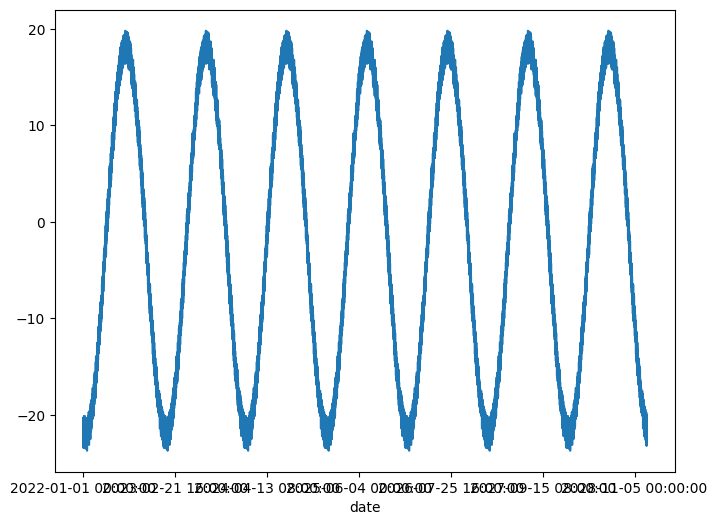

In [8]:
uni_data.plot(subplots=True)

In [9]:
uni_data = uni_data.values

Маштабирование данных.

Выполним стандартизацию набора данных с вычислением среднего значения и стандартного отклонения обучающих данных

In [10]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Выполним стандартизацию данных

In [11]:
uni_data = (uni_data - uni_train_mean) / uni_train_std

Далее подготовим данные для модели с одномерным входом.

На вход в модель будут подаваться последние 20 наблюдений за температурой, и модель необходимо обучить прогнозировать температуру на следующем шаге.

In [12]:
univariate_past_history = 20
univariate_future_target = 0
# Тестовая
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
# Валидационая
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

Результаты применения функции `univariate_data`

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.40459411]
 [-1.41869833]
 [-1.41869833]
 [-1.43280254]
 [-1.42575044]
 [-1.43985465]
 [-1.43985465]
 [-1.43280254]
 [-1.43985465]
 [-1.43280254]
 [-1.42575044]
 [-1.42575044]
 [-1.41869833]
 [-1.41869833]
 [-1.40459411]
 [-1.397542  ]
 [-1.39048989]
 [-1.37638567]
 [-1.37638567]
 [-1.36228146]]

 Target temperature to predict
-1.3552293475049326


Представим данные в виде графика

In [14]:
def create_time_steps(length):
    return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/home/danil/Projects/Python/environments/p310-env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

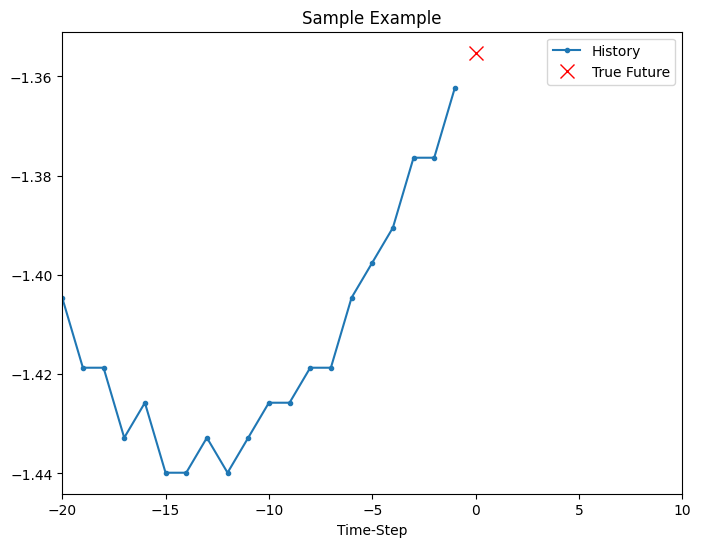

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

# **Рекуррентная нейронная сеть**

LSTM «Долгая краткосрочная память»

In [22]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [23]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Проверим выход модели

In [24]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 0s 2ms/step
(256, 1)


Обучением модели

In [25]:
EVALUATION_INTERVAL = 400
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)

Epoch 1/20


2023-04-24 01:17:28.482837: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f07741349c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-24 01:17:28.482865: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2023-04-24 01:17:28.510375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 21/400 [>.............................] - ETA: 0s - loss: 1.1215   

2023-04-24 01:17:28.809331: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 3s 3ms/step - loss: 0.2884 - val_loss: 0.0283
Epoch 2/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0192
Epoch 3/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0116
Epoch 4/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 5/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 6/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 7/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 8/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 9/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 10/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 11/2

Выполним несколько прогнозов

8/8 [==============================] - 0s 1ms/step


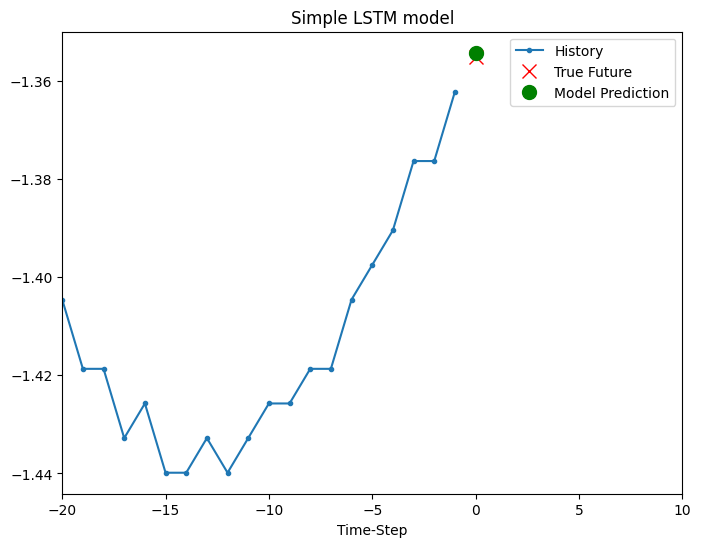

8/8 [==============================] - 0s 2ms/step


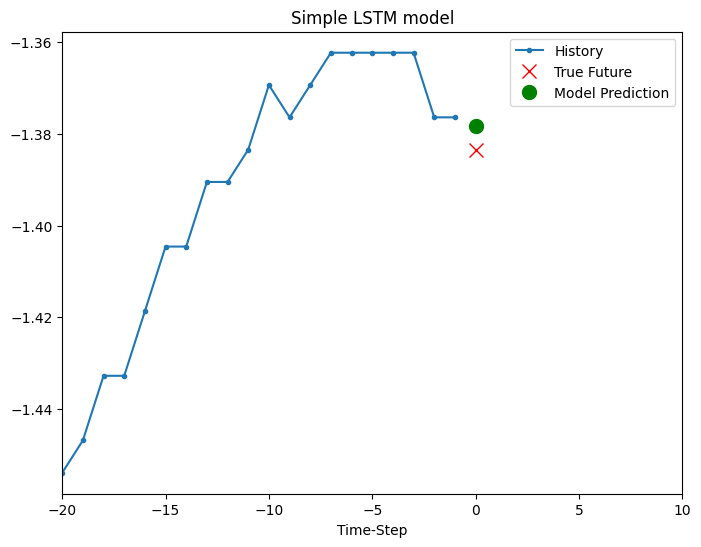

8/8 [==============================] - 0s 1ms/step


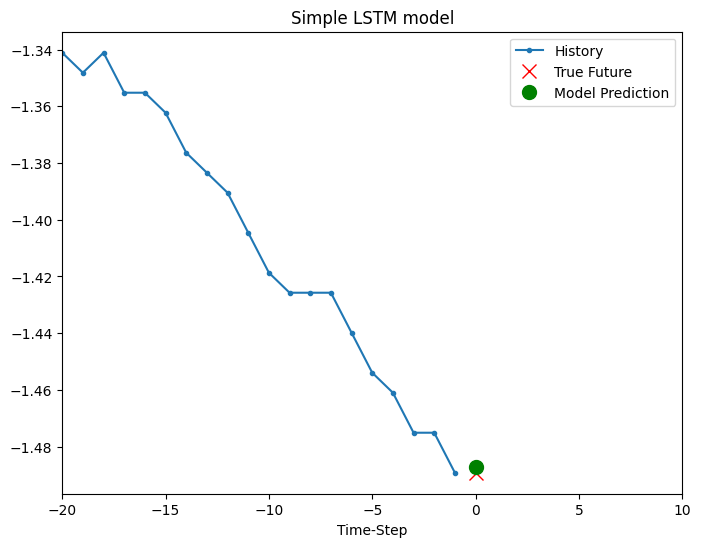

In [26]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# **Прогнозирование на основе многомерного временного ряда**

Извлечем давление, температуру и плотность воздуха из набора данных

In [27]:
features = df[['temperature', 'pressure', 'humidity']]
features.index = df['date']
features.head()

,temperature,pressure,humidity
date,,,
2022-01-01 00:00:00,-21.9,765.6,83.0
2022-01-01 00:30:00,-22.1,765.6,84.0
2022-01-01 01:00:00,-22.1,765.6,84.0
2022-01-01 01:30:00,-22.3,765.7,84.0
2022-01-01 02:00:00,-22.2,765.7,84.0


Отобразим данные на графике

array([<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>,
       <AxesSubplot: xlabel='date'>], dtype=object)

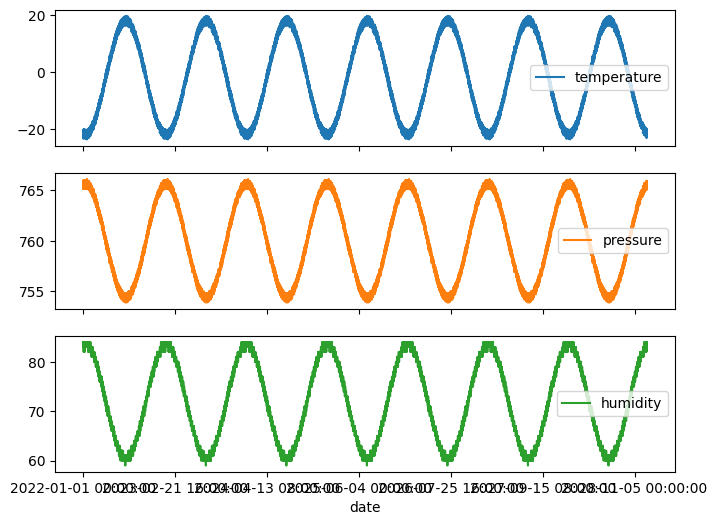

In [28]:
features.plot(subplots=True)

Маштабирование данных.

Выполним стандартизацию набора данных с вычислением среднего значения и стандартного отклонения обучающих данных

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

Выполним стандартизацию данных

In [30]:
dataset = (dataset - data_mean) / data_std

# **Точечное прогнозирование**

**Функция организации временных интервалов**

In [34]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

В данном наборе данные за последние пять суток (2 х 24 х 5 = 240). Допустим, что отбор данных проводится не каждые 30 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. Следовательно, историю последних пяти дней составляют 120 наблюдений (240/2). Для модели, выполняющей точечное прогнозирование, целью является значение температуры через 12 часов в будущем. В этом случае целевой вектор будет составлять температура после 24 (12х2) наблюдений.

In [35]:
past_history = 240
future_target = 24
STEP = 2

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

Результаты применения функции `multivariate_data`

In [36]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


**Рекуррентная нейронная сеть**

In [37]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [38]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки

In [39]:
for x, y in val_data_single.take(1):
      print(single_step_model.predict(x).shape)

8/8 [==============================] - 0s 2ms/step
(256, 1)


In [40]:
EPOCHS = 20

Обучением модели

In [41]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_single, validation_steps=50)

Epoch 1/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0752 - val_loss: 0.0421
Epoch 2/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0404 - val_loss: 0.0430
Epoch 3/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0383 - val_loss: 0.0400
Epoch 4/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0368 - val_loss: 0.0323
Epoch 5/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0357 - val_loss: 0.0330
Epoch 6/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0350 - val_loss: 0.0346
Epoch 7/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0344 - val_loss: 0.0342
Epoch 8/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0337 - val_loss: 0.0317
Epoch 9/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0332 - val_loss: 0.0297
Epoch 10/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0327 - val_loss: 0.0313

Выведим график потерь

In [42]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

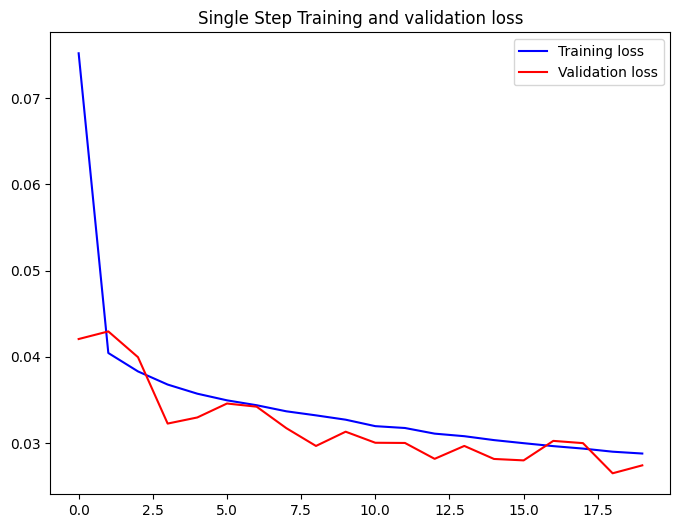

In [43]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

**Выполнение точечного прогноза**

Выполним несколько прогнозов

8/8 [==============================] - 0s 2ms/step


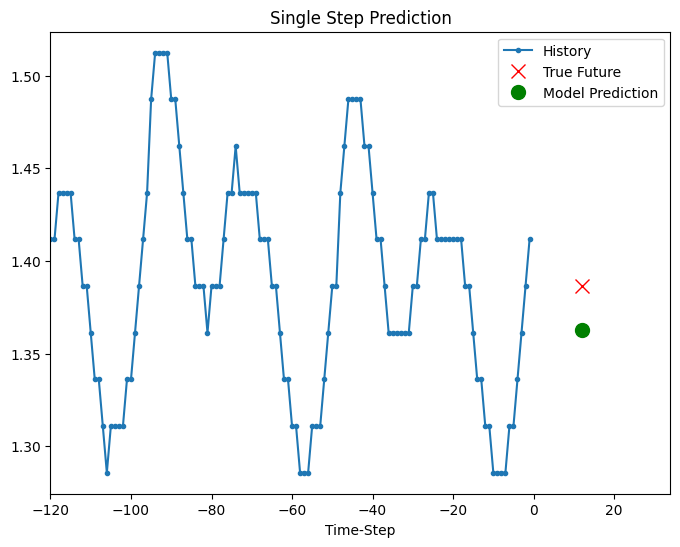

8/8 [==============================] - 0s 2ms/step


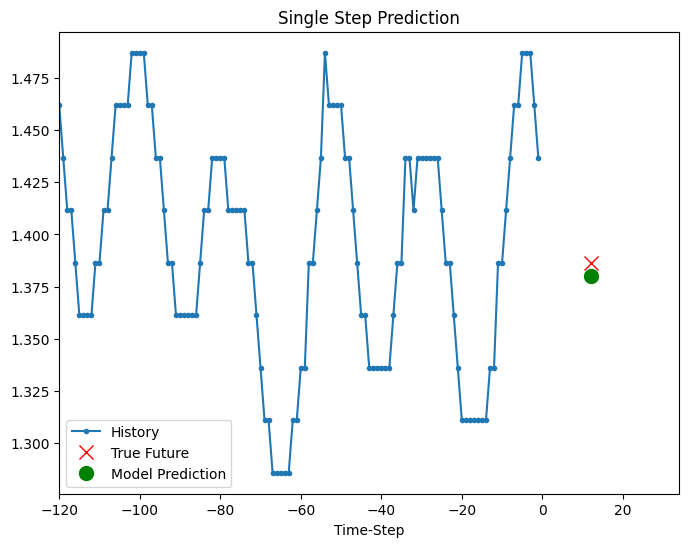

8/8 [==============================] - 0s 2ms/step


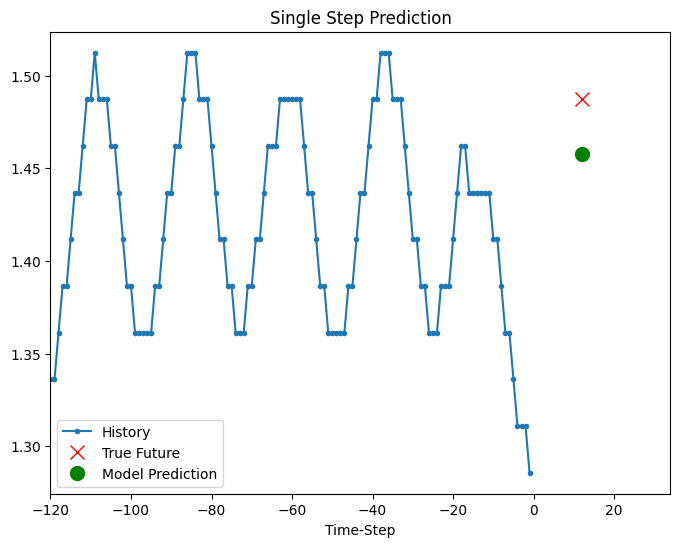

In [44]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12, 'Single Step Prediction')
    plot.show()

**Интервальное прогнозирование**

In [45]:
future_target = 24
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP)

Проверим выборку

In [46]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (24,)


In [47]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Подготовим визуализацию

In [48]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

На этом и последующих аналогичных графиках история и будущие данные ежечасные

2023-04-24 01:22:18.272183: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


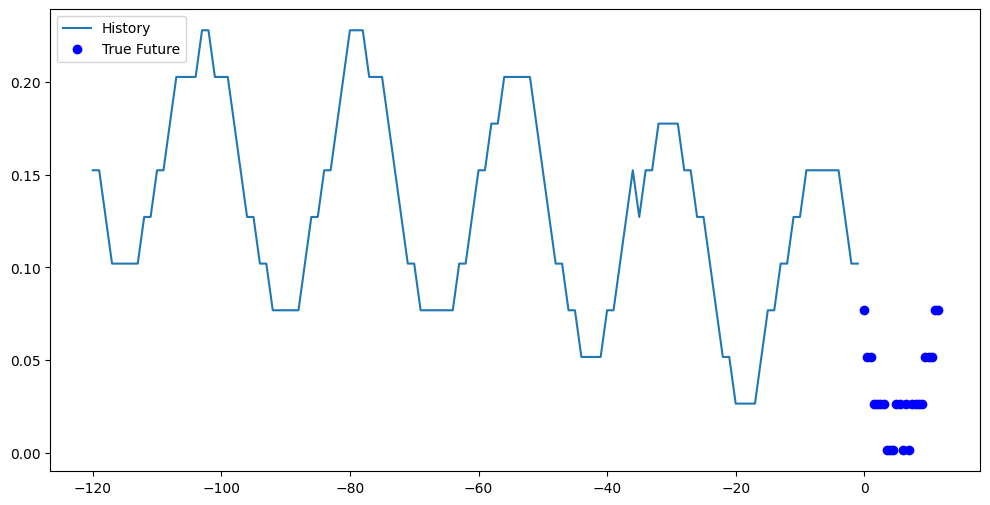

In [49]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Так как эта задача немного сложнее, чем предыдущая, то модель будет состоять из двух слоёв LSTM. Наконец, поскольку выполняется 24 прогноза, выход слой насчитывает 24 нейрона.

In [50]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16))
multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки

In [51]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

8/8 [==============================] - 0s 5ms/step
(256, 24)


In [52]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50)

Epoch 1/20
400/400 [==============================] - 6s 9ms/step - loss: 0.1499 - val_loss: 0.0627
Epoch 2/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0581 - val_loss: 0.0526
Epoch 3/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0499 - val_loss: 0.0465
Epoch 4/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0427 - val_loss: 0.0404
Epoch 5/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0378 - val_loss: 0.0327
Epoch 6/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0350 - val_loss: 0.0348
Epoch 7/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0330 - val_loss: 0.0337
Epoch 8/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0317 - val_loss: 0.0302
Epoch 9/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0307 - val_loss: 0.0280
Epoch 10/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0298 - val_loss: 0.0288

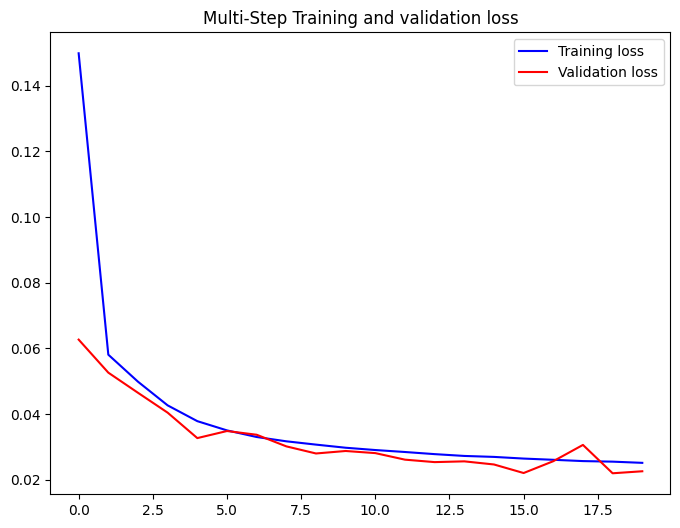

In [53]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

**Выполнение интервального прогноза**

Прогноз будущих значений температуры

8/8 [==============================] - 0s 3ms/step


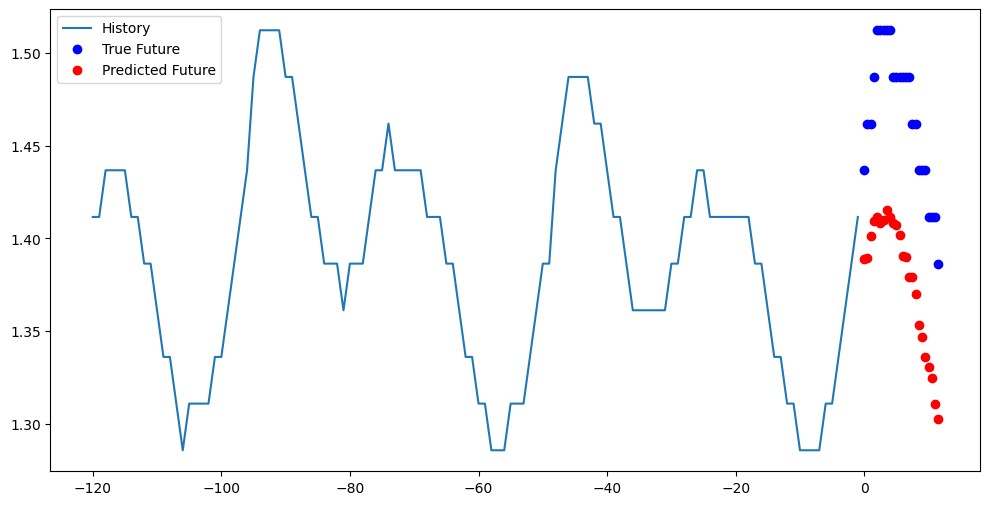

8/8 [==============================] - 0s 3ms/step


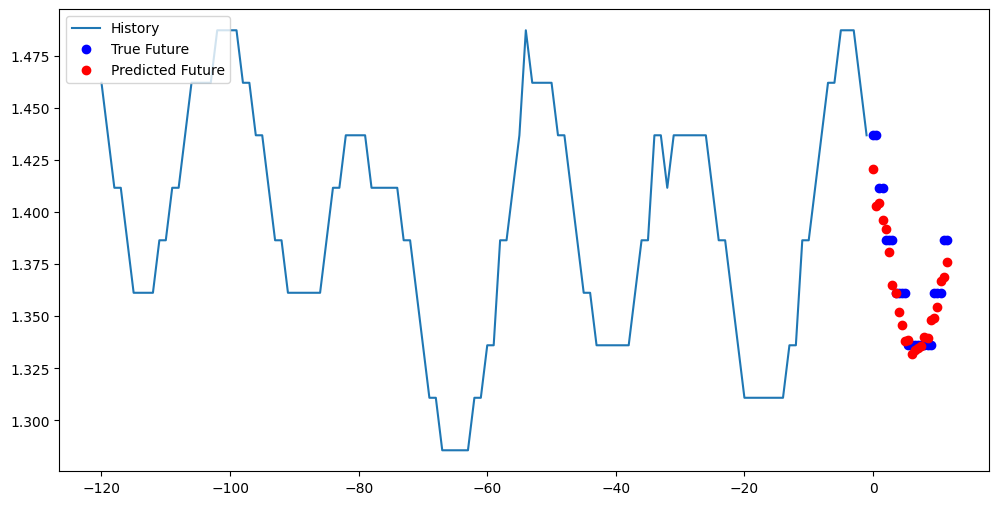

8/8 [==============================] - 0s 3ms/step


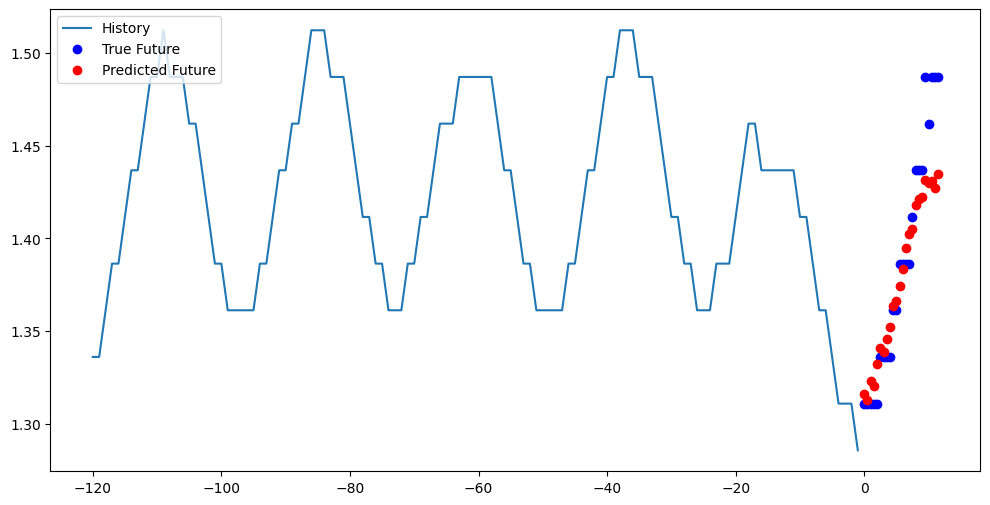

In [54]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])